© 2025. Triad National Security, LLC. All rights reserved.
This program was produced under U.S. Government contract 89233218CNA000001 for Los Alamos National Laboratory (LANL), which is operated by Triad National Security, LLC for the U.S. Department of Energy/National Nuclear Security Administration. All rights in the program are reserved by Triad National Security, LLC, and the U.S. Department of Energy/National Nuclear Security Administration. The Government is granted for itself and others acting on its behalf a nonexclusive, paid-up, irrevocable worldwide license in this material to reproduce, prepare. derivative works, distribute copies to the public, perform publicly and display publicly, and to permit others to do so.



"""
Analytic solution for Mandel's Problem (Geotechnique, 1953). Equations taken from Cheng, A. H. D., & Detournay, E. (1988). A direct boundary element method for plane strain poroelasticity..

An isotropic sample is compressed with a constant vertical foce between two rigid frictionless plates. Sample drains laterally.
"""

In [9]:
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

In [10]:

def excess_pore_pressure(t, x_array, Cv, alphas, B, F, L, v_u, sum_size = 50):
    """ Analytic solution for pressure

    Parameters
    -------------------
        t : float 
            Time in seconds
        x_array : numpy array
            x values of the domain
        Cv : float 
            coefficient of consolidation
        alphas : float
            sum constants
        B : float
            Skempten's pore pressure coefficient
        F : float
            Vertical Force (N)
        L : float 
            Horizontal Domain Length (m)
        v_u : float 
            undrained Poisson's Ratio
        sum_size : int
            truncation length of infinite sum. Default = 100

    Returns 
    -----------------
        pressure : numpy array
            pressure solution 

    Notes
    -----------------
        Infinite sum is approximated using the first sum_size values
    
    """
    print("Computing pressure ")
    a = L/2
    pressure = np.zeros_like(x_array)
    for ix, x in enumerate(x_array):
        pressure[ix] = 0
        for n in range(sum_size):
            sum_value = np.sin(alphas[n])/(alphas[n]-np.sin(alphas[n])*np.cos(alphas[n])) \
                   * (np.cos(alphas[n]*x/a) - np.cos(alphas[n])) \
                   * np.exp(-alphas[n]**2*Cv*t/a**2)
            pressure[ix] += sum_value 

    pressure = 2*F*B*(1+v_u)/(3*a) * pressure
    print("Computing pressure - done")
    return pressure


def calculate_alpha(v, v_u, sum_size=50):
    """ Calculates the alpha values needed for analytical sum 

    Parameters
    -------------------
        v : float 
            Poisson's Ratio 
        v_u : float 
            undrained Poisson's Ratio
        sum_size : int
            truncation length of infinite sum. Default = 100

    Returns 
    -----------------
        alphas : numpy array
            list of alpha values length sum_size 

    Notes
    -----------------
        In computing these we grab both positive roots, this is incredibly vague in literature 
        "(alpha_i) are constants to be  chosen on the basis of previous  experience, and are typically distributed uniformly on a logarithmic scale" 

    """
    print("\nComputing alpha values")
    alphas = [] 
    c = (1-v)/(v_u-v)

    MAXSTEPS = 100000
    NMAX = sum_size #int(np.ceil(sum_size/2))
    EPSILON = 1e-8
    for i in range(NMAX):
        x = (2 * i + 1) * np.pi / 2.0
        for j in range(MAXSTEPS):
            x = np.arctan(c * x) + i * np.pi
            if (abs(np.tan(x) - c * x) < EPSILON):
                break
        alphas.append(x)
        #alphas.append(-x)
    print("Computing alpha values - done")
    return np.array(alphas)



In [11]:

def MandelAna(t, x):
    pre = 0.0
    for i in range(NMAX):
        f1 = sin(a[i]) / (a[i] - sin(a[i]) * cos(a[i]))
        f2 = cos(a[i] * x / A) - cos(a[i])
        f3 = exp(-a[i]**2 * Cv * t / (A**2))
        f4 = exp(-a[i]**2 * t)  #nondimension t
        pre = f1 * f2 * f3 + pre
    return lamada * pre


def pick_arange(arange, num):
    if num > len(arange):
        print('out of length')
    else:
        output = np.array([], dtype=arange.dtype)
        seg = len(arange) / num
        for n in range(num):
            if int(seg * (n + 1)) >= len(arange):
                output = np.append(output, arange[-1])
            else:
                output = np.append(output, arange[int(seg * n)])
        return output



In [12]:

t = 1 #simulation time

E = 6.0e10  # Young's modulus (Pa)
v = 0.2  # possion ratio (dimensionless)
phi = 0.1  # porosity (dimensionless)
k = 3e-14  # permeability (m^2)
mu = 0.001  # Water Viscosity (Pa*s)
K_l = 2.0e9  # Water Bulk Modulus (Pa)
G = E / 2 / (1 + v)  # shear modulus

K = E / 2 / ((1 - 2 * v) * (1 + v))  # 2*G*(1+v)/3/(1-2*v) # Solid constituent Bulk Modulus (Pa)
K_s = 100 * K  # Solid grain bulk modulus (Pa)

B = 1 - phi * (K / K_l - K / K_s) / (
    (1 - K / K_s) + phi * (K / K_l - K / K_s))  # Skempton coefficient

v_u = (3 * v + B * (1 - 2 * v) *
      (1 - K / K_s)) / (3 - B * (1 - 2 * v) *
                       (1 - K / K_s))  # undraind possion ratio

P0 = 10.0e6 # Applied pressure (Pa)
F = P0 * 10 / 2 # External force (pressure*area (N)) divided by 2 because in equations external force is 2F

Cv = 2 * (k / mu) * (B**2) * G * (1 - v) * (
    (1 + v_u)**2) / 9 / (1 - v_u) / (v_u - v)  # consolidation coefficient paper1988

alphas = calculate_alpha(v, v_u) # constants for analytic sum
#time = 5 # time (s)
L = 10 # horizontal domain length (m)
dx = 0.1  # spacing of grid points (m)
Nx = np.ceil(L / dx).astype(int)  # number of grid points
x_array = np.linspace(0, L, Nx)
x_array = x_array-L/2

print("\nParameters")
print("--------------------------------------")
print(f"Applied Vertical Force\t\t{2*F} [N]")
print(f"Permeability\t\t{k} [m^2]")
print("")

pressure = excess_pore_pressure(t, x_array, Cv, alphas, B, F, L, v_u)


Computing alpha values
Computing alpha values - done

Parameters
--------------------------------------
Applied Vertical Force		100000000.0 [N]
Permeability		3e-14 [m^2]

Computing pressure 
Computing pressure - done


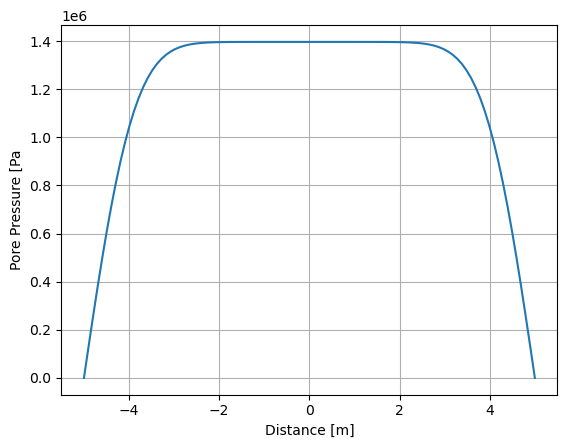

In [8]:
fig,ax = plt.subplots()
ax.plot(x_array, pressure)
ax.set_ylabel("Pore Pressure [Pa]")
ax.grid(True)
plt.xlabel("Distance [m]")
plt.show()